In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import scipy

In [2]:
experiment = 'ssp585'

zos = xr.open_dataset(f'Data_Step2/{experiment}/zos.nc')['zos'].rename({'yh':'lat', 'xh':'lon'})
col_height = xr.open_dataset(f'Data_Step2/{experiment}/col_height.nc')['col_height'].rename({'yh':'lat', 'xh':'lon'})

curlTau = xr.open_dataset(f'Data_Step2/{experiment}/curlTau.nc')['Curl_taus'].rename({'yq':'lat', 'xq':'lon'})
umo = xr.open_dataset(f'Data_Step2/{experiment}/umo_2d.nc')['umo_2d'].rename({'yh':'lat', 'xq':'lon'})
vmo = xr.open_dataset(f'Data_Step2/{experiment}/vmo_2d.nc')['vmo_2d'].rename({'yq':'lat', 'xh':'lon'})

# Ensure that longitude coords are from -180 to 180
zos.coords['lon'] = (zos.coords['lon'] + 180) % 360 - 180
zos = zos.sortby(zos.lon)

col_height.coords['lon'] = (col_height.coords['lon'] + 180) % 360 - 180
col_height = col_height.sortby(col_height.lon)

curlTau.coords['lon'] = (curlTau.coords['lon'] + 180) % 360 - 180
curlTau = curlTau.sortby(curlTau.lon)

umo.coords['lon'] = (umo.coords['lon'] + 180) % 360 - 180
umo = umo.sortby(umo.lon)

vmo.coords['lon'] = (vmo.coords['lon'] + 180) % 360 - 180
vmo = vmo.sortby(vmo.lon)

In [3]:
# curlTau is provided at grid corner points, but zos and col_height are provided at grid center points
# We regrid curlTau from corner points to center points, similarly for umo and vmo
regridder = xe.Regridder(curlTau, zos, "nearest_s2d")
curlTau = regridder(curlTau).rename('curlTau')

regridder = xe.Regridder(umo, zos, 'nearest_s2d')
umo = regridder(umo).rename('umo_2d')

regridder = xe.Regridder(vmo, zos, 'nearest_s2d')
vmo = regridder(vmo).rename('vmo_2d')

/home/William.Yik/mambaforge/envs/gfdl/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/William.Yik/mambaforge/envs/gfdl/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


## Compute lat and lon gradients of zos and col_height as well as Coriolis

In [4]:
lat = np.repeat(zos['lat'].values[:, np.newaxis], len(zos['lon']), axis=1)

lonRoll = np.roll(lat, axis=0, shift=-1)
Londiff = lonRoll - lat  # equivalent to doing x_{i} - x_{i-1}

# side length of grid box at 1 degree resolution (near equator)
# divided by 4 since we are at 1/4 degree resolution
latDiff = 1.111774765625000e+05 / 4 
latY=np.gradient(lat, axis=0)*latDiff
lonX=np.abs(np.cos(lat*np.pi/180))*latDiff*Londiff

##coriolis 
Omega=7.2921e-5 # coriolis parameter
f = (2*Omega*np.sin(lat*np.pi/180))

def grad(d,y,x):
    grady=np.gradient(d, axis=0)/y
    gradx=np.gradient(d, axis=1)/x
    return grady, gradx

gradZos_y, gradZos_x = grad(zos,latY,lonX)
gradColHeight_y, gradColHeight_x = grad(col_height,latY,lonX)
gradF_y, gradF_x = grad(f,latY,lonX)

In [5]:
gradZos_x_xr = xr.DataArray(data=gradZos_x,
                            dims=['lat','lon'],
                            coords=dict(lat=zos['lat'], lon=zos['lon']),
                            name='gradZos_x')
gradZos_y_xr = xr.DataArray(data=gradZos_y,
                            dims=['lat','lon'],
                            coords=dict(lat=zos['lat'], lon=zos['lon']),
                            name='gradZos_y')
gradColHeight_x_xr = xr.DataArray(data=gradColHeight_x,
                                  dims=['lat','lon'],
                                  coords=dict(lat=zos['lat'], lon=zos['lon']),
                                  name='gradColHeight_x')
gradColHeight_y_xr = xr.DataArray(data=gradColHeight_y,
                                  dims=['lat','lon'],
                                  coords=dict(lat=zos['lat'], lon=zos['lon']),
                                  name='gradColHeight_y')
f_xr = xr.DataArray(data=f,
                    dims=['lat','lon'],
                    coords=dict(lat=zos['lat'], lon=zos['lon']),
                    name='f')

In [6]:
input_fields = xr.merge([curlTau, col_height, zos, f_xr, gradColHeight_x_xr,
                         gradColHeight_y_xr, gradZos_x_xr, gradZos_y_xr, umo, vmo])
input_fields

<xarray.Dataset>
Dimensions:          (lon: 1440, lat: 1080)
Coordinates:
  * lon              (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * lat              (lat) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
Data variables:
    curlTau          (lat, lon) float64 nan nan nan ... 8.334e-10 8.334e-10
    col_height       (lat, lon) float32 nan nan nan ... 3.302e+03 3.313e+03
    zos              (lat, lon) float32 nan nan nan ... -0.2977 -0.2949 -0.2923
    f                (lat, lon) float64 -0.0001438 -0.0001438 ... 0.0001458
    gradColHeight_x  (lat, lon) float64 nan nan nan ... -0.001484 -0.002426
    gradColHeight_y  (lat, lon) float64 nan nan nan ... -0.004875 -0.002621
    gradZos_x        (lat, lon) float64 nan nan nan ... -6e-07 -5.741e-07
    gradZos_y        (lat, lon) float64 nan nan nan ... -2.357e-07 -1.902e-07
    umo_2d           (lat, lon) float64 nan nan nan ... 4.315e+07 3.619e+07
    vmo_2d           (lat, lon) float64 nan nan nan ... 3.9e+07 3.9e+07 3.9e+07
Attributes:
    regrid_method:  nearest_s2d

In [7]:
input_fields.to_netcdf(f'Data_Step2/{experiment}/input_fields.nc')

## Visualize input features

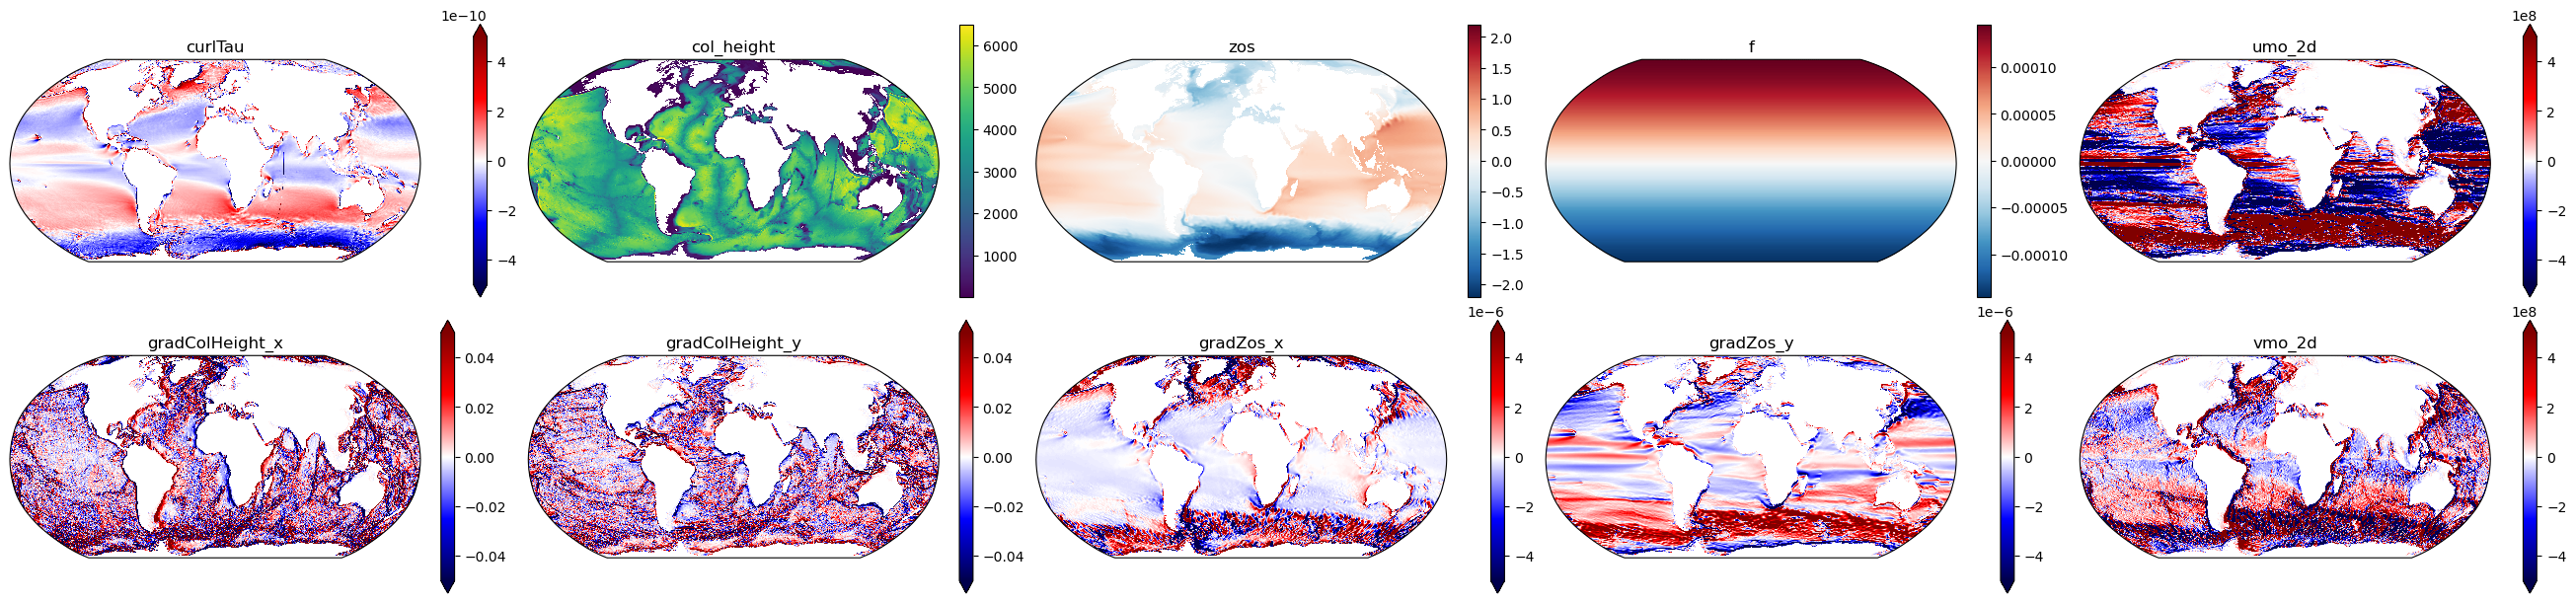

In [8]:
fig, axes = plt.subplots(2, 5, subplot_kw={'projection':ccrs.Robinson()}, figsize=(26,6), constrained_layout=True)

curlTau.plot(ax=axes[0,0], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-10, vmax=5e-10)
axes[0,0].set_title('curlTau')

col_height.plot(ax=axes[0,1], transform=ccrs.PlateCarree(), add_labels=False)
axes[0,1].set_title('col_height')

zos.plot(ax=axes[0,2], transform=ccrs.PlateCarree(), add_labels=False)
axes[0,2].set_title('zos')

f_xr.plot(ax=axes[0,3], transform=ccrs.PlateCarree(), add_labels=False)
axes[0,3].set_title('f')

gradColHeight_x_xr.plot(ax=axes[1,0], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-2, vmax=5e-2)
axes[1,0].set_title('gradColHeight_x')

gradColHeight_y_xr.plot(ax=axes[1,1], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-2, vmax=5e-2)
axes[1,1].set_title('gradColHeight_y')

gradZos_x_xr.plot(ax=axes[1,2], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-6, vmax=5e-6)
axes[1,2].set_title('gradZos_x')

gradZos_y_xr.plot(ax=axes[1,3], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-6, vmax=5e-6)
axes[1,3].set_title('gradZos_y')

umo.plot(ax=axes[0,4], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e8, vmax=5e8)
axes[0,4].set_title('umo_2d')

vmo.plot(ax=axes[1,4], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e8, vmax=5e8)
axes[1,4].set_title('vmo_2d')

plt.show()

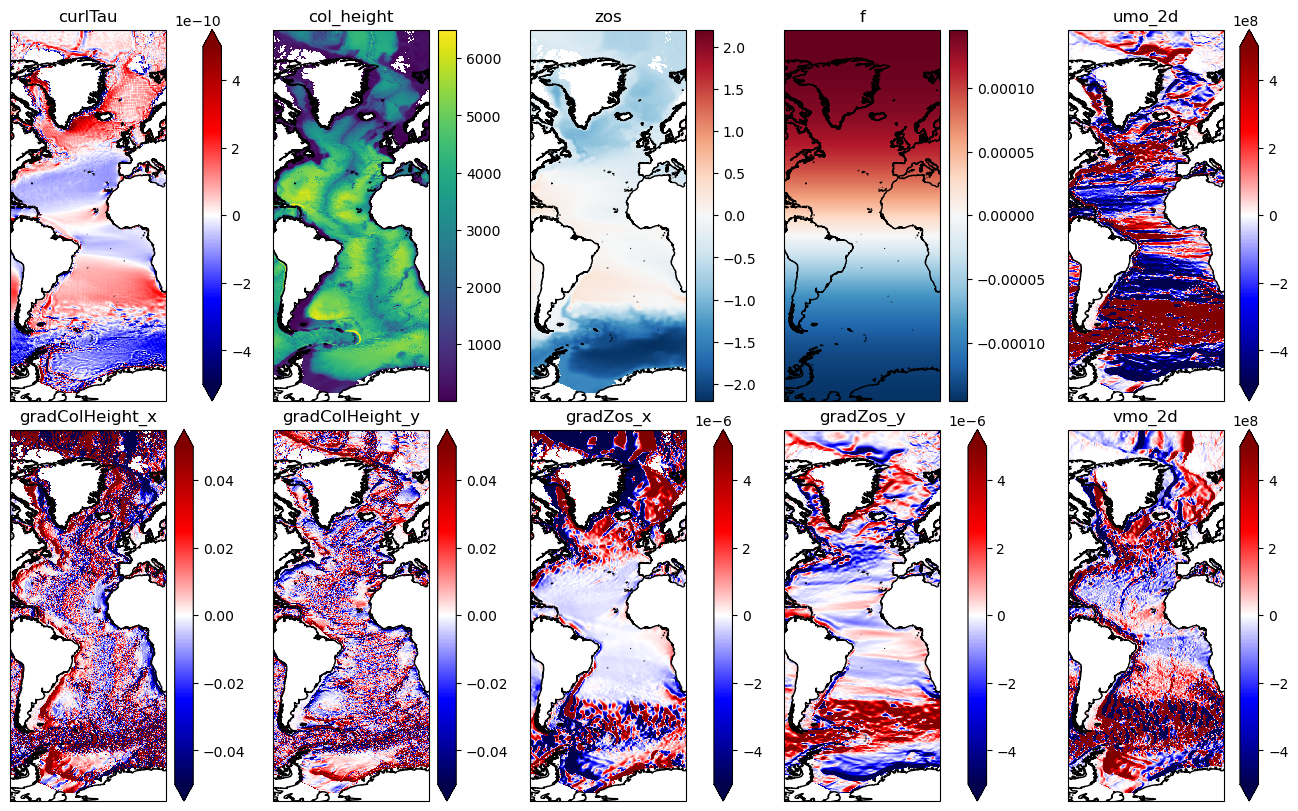

In [9]:
fig, axes = plt.subplots(2, 5, subplot_kw={'projection':ccrs.Miller()}, figsize=(13,8), constrained_layout=True)

curlTau.isel(lon=slice(400,800)).plot(ax=axes[0,0], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-10, vmax=5e-10)
axes[0,0].set_title('curlTau')
axes[0,0].coastlines(resolution='10m')

col_height.isel(lon=slice(400,800)).plot(ax=axes[0,1], transform=ccrs.PlateCarree(), add_labels=False)
axes[0,1].set_title('col_height')
axes[0,1].coastlines(resolution='10m')

zos.isel(lon=slice(400,800)).plot(ax=axes[0,2], transform=ccrs.PlateCarree(), add_labels=False, cmap='RdBu_r')
axes[0,2].set_title('zos')
axes[0,2].coastlines(resolution='10m')

f_xr.isel(lon=slice(400,800)).plot(ax=axes[0,3], transform=ccrs.PlateCarree(), add_labels=False)
axes[0,3].set_title('f')
axes[0,3].coastlines(resolution='10m')

gradColHeight_x_xr.isel(lon=slice(400,800)).plot(ax=axes[1,0], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-2, vmax=5e-2)
axes[1,0].set_title('gradColHeight_x')
axes[1,0].coastlines(resolution='10m')

gradColHeight_y_xr.isel(lon=slice(400,800)).plot(ax=axes[1,1], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-2, vmax=5e-2)
axes[1,1].set_title('gradColHeight_y')
axes[1,1].coastlines(resolution='10m')

gradZos_x_xr.isel(lon=slice(400,800)).plot(ax=axes[1,2], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-6, vmax=5e-6)
axes[1,2].set_title('gradZos_x')
axes[1,2].coastlines(resolution='10m')

gradZos_y_xr.isel(lon=slice(400,800)).plot(ax=axes[1,3], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e-6, vmax=5e-6)
axes[1,3].set_title('gradZos_y')
axes[1,3].coastlines(resolution='10m')

umo.isel(lon=slice(400,800)).plot(ax=axes[0,4], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e8, vmax=5e8)
axes[0,4].set_title('umo_2d')
axes[0,4].coastlines(resolution='10m')

vmo.isel(lon=slice(400,800)).plot(ax=axes[1,4], transform=ccrs.PlateCarree(), add_labels=False, cmap='seismic', vmin=-5e8, vmax=5e8)
axes[1,4].set_title('vmo_2d')
axes[1,4].coastlines(resolution='10m')

plt.show()

## Get MOM6 labels (6 clusters found with NEMI)

In [10]:
num_clusters = 6
mom6_labels = xr.open_dataset(f'Data_Step2/control/mom6_labels_{num_clusters}_clusters.nc')['Label']

# Ensure that longitude coords are from -180 to 180
mom6_labels.coords['lon'] = (mom6_labels.coords['lon'] + 180) % 360 - 180
mom6_labels = mom6_labels.sortby(mom6_labels.lon)

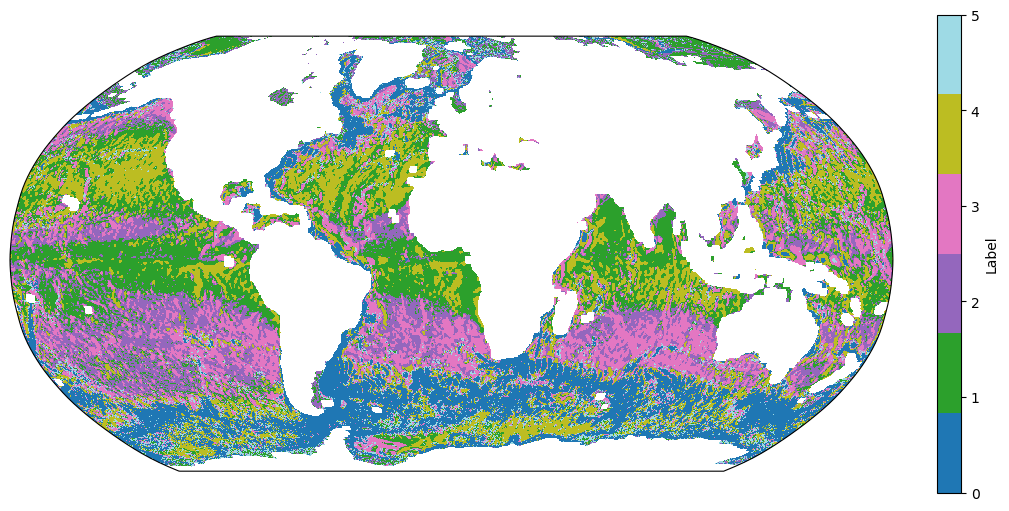

In [11]:
fig, axes = plt.subplots(1, 1, subplot_kw={'projection':ccrs.Robinson()}, figsize=(10,5), constrained_layout=True)
mom6_labels.plot(ax=axes, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('tab20', num_clusters))
plt.show()

## Split data into training and test sets

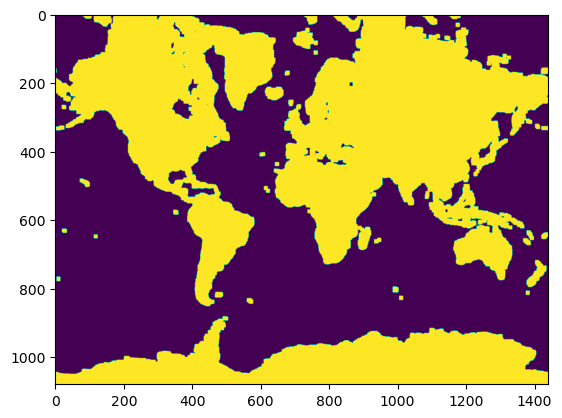

In [12]:
missingdataindex = np.isnan(mom6_labels*curlTau*col_height*zos*f*gradColHeight_x*gradColHeight_y*gradZos_x*gradZos_y*umo*vmo)    
plt.imshow(np.flipud(missingdataindex))
plt.show()

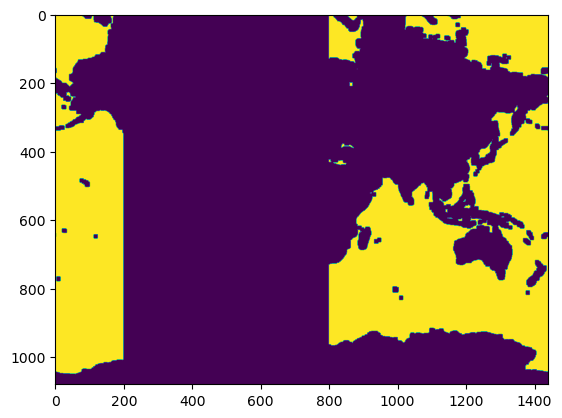

In [13]:
maskTraining = (~missingdataindex).copy()
# East Pacific as validation
maskTraining[:,200:800]=False
# West Pacific as validation
# maskTraining[:,list(range(400,800))+list(range(1240,1440))]=False
plt.imshow(np.flipud(maskTraining))
plt.show()

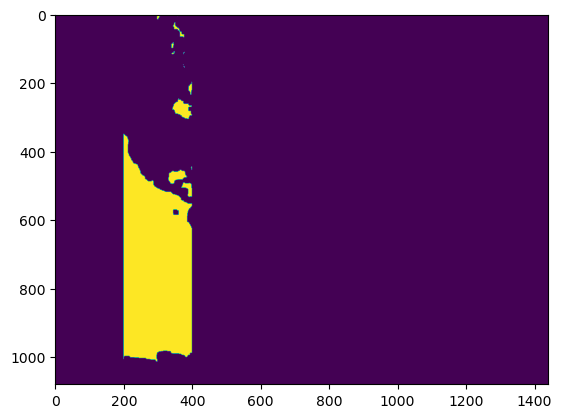

In [14]:
maskVal = (~missingdataindex).copy()
# East Pacific as validation
maskVal[:,list(range(0,200))+list(range(400,1440))]=False
# West Pacific as validation
# maskVal[:,:1240]=False
plt.imshow(np.flipud(maskVal))
plt.show()

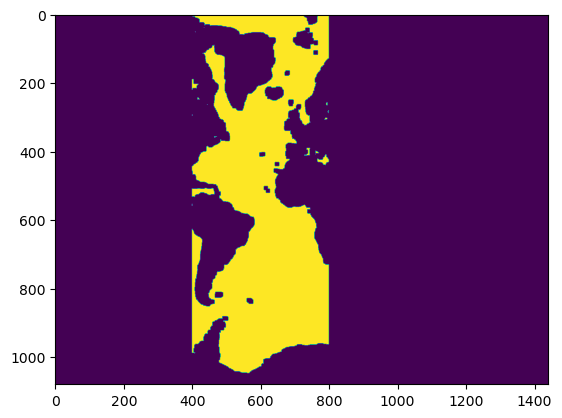

In [15]:
maskTest = (~missingdataindex).copy()
maskTest[:,list(range(400))+list(range(800,1440))]=False
plt.imshow(np.flipud(maskTest))
plt.show()

In [16]:
np.save(f'Data_Step2/{experiment}/missingdataindex.npy', missingdataindex)
np.save(f'Data_Step2/{experiment}/maskTraining.npy', maskTraining)
np.save(f'Data_Step2/{experiment}/maskVal.npy', maskVal)
np.save(f'Data_Step2/{experiment}/maskTest.npy', maskTest)

In [17]:
total_features = xr.where(~missingdataindex, input_fields, np.nan).to_array().data.reshape(10,1080*1440).transpose()
train_features = xr.where(maskTraining, input_fields, np.nan).to_array().data.reshape(10,1080*1440).transpose()
val_features = xr.where(maskVal, input_fields, np.nan).to_array().data.reshape(10,1080*1440).transpose()
test_features = xr.where(maskTest, input_fields, np.nan).to_array().data.reshape(10,1080*1440).transpose()

# Remove rows containing nans
total_features = total_features[~np.isnan(total_features).any(axis=1)]
train_features = train_features[~np.isnan(train_features).any(axis=1)]
val_features = val_features[~np.isnan(val_features).any(axis=1)]
test_features = test_features[~np.isnan(test_features).any(axis=1)]

total_features.shape, train_features.shape, val_features.shape, test_features.shape

((834418, 10), (481049, 10), (105337, 10), (248032, 10))

In [18]:
if experiment == 'control':
    total_labels = mom6_labels.values[~missingdataindex]
    train_labels = mom6_labels.values[maskTraining]
    val_labels = mom6_labels.values[maskVal]
    test_labels = mom6_labels.values[maskTest]

    print(total_labels.shape, train_labels.shape, val_labels.shape, test_labels.shape)

In [19]:
np.save(f'Data_Step2/{experiment}/total_features.npy', total_features)
np.save(f'Data_Step2/{experiment}/train_features.npy', train_features)
np.save(f'Data_Step2/{experiment}/val_features.npy', val_features)
np.save(f'Data_Step2/{experiment}/test_features.npy', test_features)

if experiment == 'control':
    np.save(f'Data_Step2/{experiment}/total_labels_{num_clusters}_clusters.npy', total_labels)
    np.save(f'Data_Step2/{experiment}/train_labels_{num_clusters}_clusters.npy', train_labels)
    np.save(f'Data_Step2/{experiment}/val_labels_{num_clusters}_clusters.npy', val_labels)
    np.save(f'Data_Step2/{experiment}/test_labels_{num_clusters}_clusters.npy', test_labels)